In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Loading Train / Test dataset from FashionMNIST 
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [3]:
image, label = trainingdata[0]
print(image.shape, label)
# Squeeze the function to get rid of the first dimention
print(image.squeeze().shape)

torch.Size([1, 28, 28]) 9
torch.Size([28, 28])


In [4]:
# Converting dataset to dataloader because it is easier for iteration process
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

In [5]:
# Length of the dataloader totally depends on the batch size
# Approximately the size of the dataloader = size of the dataset / size of the batch
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


torch.Size([64, 1, 28, 28]) torch.Size([64])


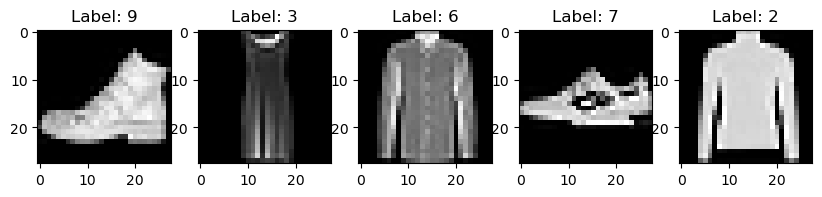

In [6]:
# The 'iter' function goes through training dataloader
images, labels = next(iter(trainDataLoader))
print(images.shape, labels.shape)
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
    plt.subplot(1,5,index+1)
    plt.title(f'Label: {labels[index].item()}')
    plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

In [7]:
# Building Model - Dense Layer
# Creating Neural Network Model with three hidden layers with 256,128,64 neurons 
# This classification task has 10 classes so the corresponding output layer has 10 outputs
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # For avoiding further error because of input size, we need to flatten images here
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(28*28, 256) # Hidden layer 1
        self.fc2 = torch.nn.Linear(256, 128)   # Hidden layer 2
        self.fc3 = torch.nn.Linear(128, 64)    # Hidden layer 3
        self.fc4 = torch.nn.Linear(64, 10)     # Output layer
    
    # Defining ReLU activation function for each layer
    def forward(self, x):
        x = self.flatten(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.log_softmax(self.fc4(x), dim=1)
        
        return x

In [8]:
# My PyTorch doesn't support .cuda()
model = Net() # Step 1: architecture
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method

In [9]:
# How good our model is going to be
train_loss_history = []
test_loss_history = []

for epoch in range(25):
    train_loss = 0.0
    test_loss = 0.0
    
    # we are interested in updating trainable parameters
    model.train()
    for i, data in enumerate(trainDataLoader):
        # If the model was on the GPU image also need to be on GPU
        images, labels = data
        # zero out any gradient values from the previous iteration
        optimizer.zero_grad() 
        # forward propagation - as long as we feed image to model it will do the forward computation
        predicted_output = model(images) 
        # calculate our measure of goodness
        fit = loss(predicted_output, labels)
        # backpropagation
        fit.backward() 
        # update the weights of our trainable parameters
        optimizer.step() 
        train_loss += fit.item()
        
    # we are interested in evaluation
    model.eval()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images
            labels = labels
            predicted_output = model(images)
            fit = loss(predicted_output, labels)
            test_loss += fit.item()
        
    train_loss = train_loss / len(trainDataLoader)
    test_loss = test_loss / len(testDataLoader)
    train_loss_history += [train_loss]
    test_loss_history += [test_loss]
    print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')


Epoch 0, Train loss 1.9121830203512837, Test loss 1.102645098783408
Epoch 1, Train loss 0.868343027669992, Test loss 0.7732926426799434
Epoch 2, Train loss 0.6941596802109594, Test loss 0.6742507644519684
Epoch 3, Train loss 0.6042940981352507, Test loss 0.5874925138084752
Epoch 4, Train loss 0.5486228838404105, Test loss 0.5698287843898603
Epoch 5, Train loss 0.5110969311996564, Test loss 0.5309731766676448
Epoch 6, Train loss 0.48382637081052193, Test loss 0.516586343953564
Epoch 7, Train loss 0.46303813769492, Test loss 0.4898860494422305
Epoch 8, Train loss 0.44730533112976345, Test loss 0.4899890762605485
Epoch 9, Train loss 0.4340112950406603, Test loss 0.5052892692909119
Epoch 10, Train loss 0.4240220821043576, Test loss 0.46073572973536836
Epoch 11, Train loss 0.41236806727612196, Test loss 0.4509838547106761
Epoch 12, Train loss 0.4029288757552724, Test loss 0.4419877255798145
Epoch 13, Train loss 0.39447594403839314, Test loss 0.45065410501638037
Epoch 14, Train loss 0.385526

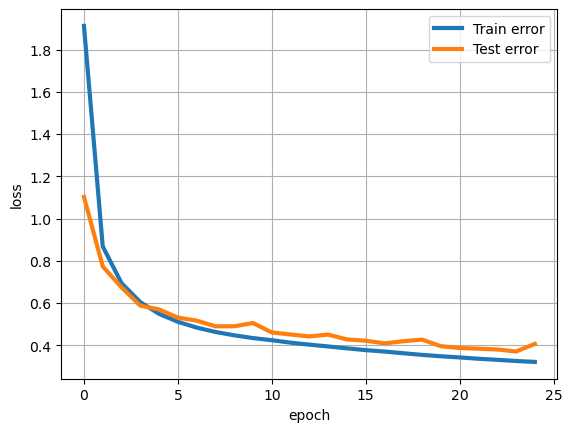

In [10]:
plt.plot(range(25),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(25),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 1, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
0.19858230650424957


Text(0.5, 1.0, 'Pred: 1, True: 2')

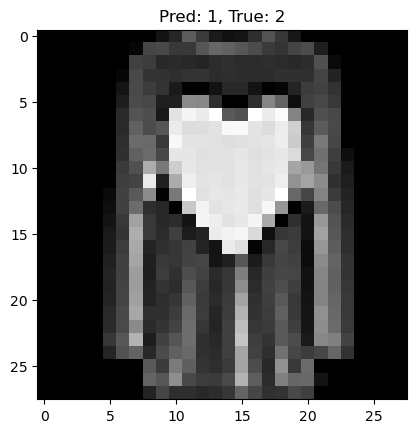

In [13]:
# Showing image that incorrectly have been detected
plt.imshow(images[1].squeeze(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')